In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [ ]:
!pip install -q tensorflow-text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_clean=pd.read_csv('/content/drive/MyDrive/katia/clean_data.csv', sep='\t')
df_clean

,Unnamed: 0,title,text,subject,date,label
0,14137,german police detain suspect global online dru...,berlin reuters german police detained 29yearol...,worldnews,2017-11-22,0
1,6860,audit obamas irs misled american get sign obam...,soooo irs lied american prod comply sign obama...,Government News,2017-08-04,1
2,2204,republican total control state collapse,bobby jindal abandoned home state louisiana mo...,News,2016-03-04,1
3,19174,cant make black man win 16 million suing black...,word yet whether hispanic question referred pl...,politics,2015-09-13,1
4,1020,judge reject bid 18 state revive obamacare sub...,san franciscowashington reuters u judge wednes...,politicsNews,2017-10-25,0
...,...,...,...,...,...,...
44862,9741,high road martin luther king iii meet trump ti...,martin luther king iii met presidentelect dona...,politics,2017-01-16,1
44863,6424,watch gw bush gush kimmels antitrump oscar mon...,george w bush heaped praise jimmy kimmel antit...,left-news,2017-03-03,1
44864,840,failure leadership obama hillary fine leading ...,ad fantastic really nail failure leadership ob...,politics,2015-12-11,1
44865,12703,sri lanka parliament back tax exemption port d...,colombo reuters sri lanka parliament approved ...,worldnews,2017-12-08,0


In [ ]:
nan_values = df_clean['text'].isna()

In [ ]:
for col in df_clean['text'].index:
  if nan_values[col]:
    df_clean = df_clean.drop(labels=col, axis=0)
df_clean['text'].sort_values()    

18866    1 7 antitrump rally raging across america make...
41733    1 7 antitrump rally raging across america make...
33830    1 christian2 gay3 fear lifestyle put odds bibl...
31720    1 disarm federal regulatory agenciesduring eig...
13237    1 disarm federal regulatory agenciesduring eig...
                               ...                        
41632    zurich reuters switzerland stop seizing income...
9605     zurich reuters switzerland stripped libyan mus...
26079    zurich reuters switzerland sunday called quick...
16970    zurich reuters three people died separate aval...
25983    zurich reuters united state consular office sw...
Name: text, Length: 44235, dtype: object

In [ ]:
df_clean["label"].value_counts()

1    22819
0    21416
Name: label, dtype: int64

## Preprocessing

In [ ]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
preprocess_url = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')
encoder_url = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3')

In [ ]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

## Training model (text)

In [ ]:
#Split the dataset
#test_size=0.2, random_state=7, stratify=df_clean['label']
x_train,x_test,y_train,y_test=train_test_split(df_clean['text'], df_clean['label'],test_size=0.2, random_state=7 )

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 30 == 0:
        lr *= 0.2
        
    return max(lr, 3e-7)

In [ ]:
model_history = model.fit(
    x_train, y_train,
    epochs=50,
    steps_per_epoch=20,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ])

Epoch 1/50
20/20 [==============================] - 37s 2s/step - loss: 0.6760 - accuracy: 0.5727 - precision: 0.5749 - recall: 0.6644 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 34s 2s/step - loss: 0.6247 - accuracy: 0.6953 - precision: 0.6904 - recall: 0.7151 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 34s 2s/step - loss: 0.5955 - accuracy: 0.7383 - precision: 0.7309 - recall: 0.7817 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 34s 2s/step - loss: 0.5683 - accuracy: 0.7703 - precision: 0.7438 - recall: 0.8443 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 36s 2s/step - loss: 0.5335 - accuracy: 0.8047 - precision: 0.7950 - recall: 0.8382 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 34s 2s/step - loss: 0.5088 - accuracy: 0.8273 - precision: 0.8001 - recall: 0.8903 - lr: 0.0010
Epoch 7/50
20/20 [==============================] - 34s 2s/step - loss: 0.4914 - accuracy: 0.8230 - precision: 0

In [ ]:
model_history.history

{'loss': [0.6759575009346008,
  0.6247251629829407,
  0.5955091714859009,
  0.5683090686798096,
  0.5335021018981934,
  0.5087817311286926,
  0.4914364218711853,
  0.4683711528778076,
  0.4627559185028076,
  0.4553132951259613,
  0.4372301697731018,
  0.4328688681125641,
  0.4135172367095947,
  0.4056585729122162,
  0.40671032667160034,
  0.39481988549232483,
  0.3946169912815094,
  0.3841913342475891,
  0.3714134991168976,
  0.3802025020122528,
  0.3683016002178192,
  0.363741397857666,
  0.35915663838386536,
  0.34910425543785095,
  0.34848347306251526,
  0.35808804631233215,
  0.3405125141143799,
  0.3645428419113159,
  0.3407728970050812,
  0.34035560488700867,
  0.32916003465652466,
  0.34086474776268005,
  0.3389912247657776,
  0.336714506149292,
  0.33425286412239075,
  0.3315059542655945,
  0.34007182717323303,
  0.3386889100074768,
  0.3457283079624176,
  0.3362904191017151,
  0.32550668716430664,
  0.337016224861145,
  0.3318178653717041,
  0.32811594009399414,
  0.3346149325

In [ ]:
model.save_weights("/content/drive/MyDrive/katia/model_2.h5")

In [ ]:
model.load_weights("/content/drive/MyDrive/katia/model_100_100_fixed.h5")

In [ ]:
model.evaluate(x_test, y_test)

277/277 [==============================] - 96s 339ms/step - loss: 0.3171 - accuracy: 0.8766 - precision: 0.8660 - recall: 0.9015


[0.31710630655288696,
 0.8765683174133301,
 0.8659966588020325,
 0.901482105255127]

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

277/277 [==============================] - 94s 338ms/step


In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

#Build confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[3619,  640],
       [ 452, 4136]])

Text(33.0, 0.5, 'Truth')

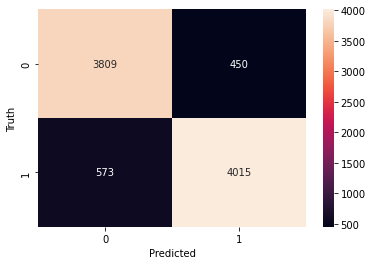

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4259
           1       0.90      0.88      0.89      4588

    accuracy                           0.88      8847
   macro avg       0.88      0.88      0.88      8847
weighted avg       0.88      0.88      0.88      8847



Example

In [ ]:
reviews = [
    "TRUMP ARRIVES IN MOBILE, ALABAMA TO SAY THANKS", 
    "Trump says Russia probe will be fair, but timeline unclear: NYT",
    "Virginia officials postpone lottery drawing to decide tied statehouse election",
    "Trump on Twitter (Dec 26) - Hillary Clinton, Tax Cut Bill"]
model.predict(reviews)

1/1 [==============================] - 1s 846ms/step


array([[0.51965785],
       [0.23493822],
       [0.01219416],
       [0.7789744 ]], dtype=float32)